In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

from hts.hierarchy import HierarchyTree
from hts import HTSRegressor
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
sales = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
cal = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/calendar.csv')

In [3]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [4]:
#take the dataframe and only present the relevant category
def filter_aggregate_sales(frame, column_to_filter, column_value_to_filter, column_to_aggregate):
    frame = frame[frame[column_to_filter] == column_value_to_filter]
    frame = frame.groupby(column_to_aggregate).sum().T
    return frame

In [5]:
filter_aggregate_sales(frame=sales, column_to_filter='state_id', column_value_to_filter='CA', column_to_aggregate='state_id')

state_id,CA
d_1,14195
d_2,13805
d_3,10108
d_4,11047
d_5,9925
...,...
d_1937,15678
d_1938,16297
d_1939,17430
d_1940,23103


In [6]:
#merge sales with calendar 
def merge_pd(frame1, frame2, merge_index):
    mergedframe = pd.merge(frame1, frame2, on = merge_index, how = 'inner')
    mergedframe.date = pd.to_datetime(mergedframe.date)
    mergedframe = mergedframe.drop(['wm_yr_wk', 'weekday', 'year', 'd', 'event_name_1', 'event_name_2', 
                                      'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'wday', 'month',
                                   'event_type_1'], axis='columns')
    return mergedframe

In [7]:
#Create hierarchical dataframe by summing for each category or sub-category
def summedlist(frame, col_to_filter):
    for state in frame[col_to_filter].unique():
        states[state] = filter_aggregate_sales(frame=frame, column_to_filter=col_to_filter, column_value_to_filter=state,
                                           column_to_aggregate=col_to_filter)[state]
    return states

In [8]:
list_of_cols = ['state_id', 'store_id', 'cat_id', 'dept_id'] 
type(list_of_cols)

list

In [9]:
#test = summedlist(sales, list_of_cols)
#test

In [10]:
states = filter_aggregate_sales(frame=sales, column_to_filter='state_id', column_value_to_filter='CA',
                                   column_to_aggregate='state_id')
states['CA']

d_1       14195
d_2       13805
d_3       10108
d_4       11047
d_5        9925
          ...  
d_1937    15678
d_1938    16297
d_1939    17430
d_1940    23103
d_1941    24644
Name: CA, Length: 1941, dtype: int64

In [11]:
sales.state_id.unique()

array(['CA', 'TX', 'WI'], dtype=object)

In [12]:
#Create hierarchical dataframe
summedlistframe = pd.DataFrame()
for state in sales.state_id.unique():
    summedlistframe[state] = filter_aggregate_sales(frame=sales, column_to_filter='state_id', column_value_to_filter=state,
                                                  column_to_aggregate='state_id')[state]

for store in sales.store_id.unique():
    summedlistframe[store] = filter_aggregate_sales(frame=sales, column_to_filter='store_id', column_value_to_filter=store,
                                                    column_to_aggregate='store_id')[store]  

for category in sales.cat_id.unique():
    summedlistframe[category] = filter_aggregate_sales(frame=sales, column_to_filter='cat_id', column_value_to_filter=category,
                                                       column_to_aggregate='cat_id')[category]
for dept in sales.dept_id.unique():
    summedlistframe[dept] = filter_aggregate_sales(frame=sales, column_to_filter='dept_id', column_value_to_filter=dept,
                                                       column_to_aggregate='dept_id')[dept]
summedlistframe['total'] = summedlistframe.CA + summedlistframe.TX + summedlistframe.WI
#states2 = states.reset_index()
#states2 = states2.rename(columns={'index':'d'})
summedlistframe.head()

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
d_1,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
d_2,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
d_3,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
d_4,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
d_5,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146


In [13]:
summedlistframe = summedlistframe.reset_index()
summedlistframe = summedlistframe.rename({'index':'d'}, axis='columns')

In [14]:
summedlistframe.head()

,d,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
0,d_1,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
1,d_2,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
2,d_3,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
3,d_4,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
4,d_5,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146


In [15]:
#add date as the index 
combinedframe = merge_pd(frame1=summedlistframe, frame2=cal, merge_index='d')
combinedframe = combinedframe.set_index('date')
combinedframe.head()

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
2011-01-30,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
2011-01-31,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
2011-02-01,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
2011-02-02,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146


In [16]:
combinedframe.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

In [17]:
#Categorize the names in each col
state = sales.state_id.unique()
store = sales.store_id.unique()
dept = sales.dept_id.unique()
cat = sales.cat_id.unique()
items = sales.id.unique()

In [18]:
#create a dictionary for each category to form a tree 
total = {'total': list(state)}
state_h = {k: [v for v in store if v.startswith(k)] for k in state}
store_h = {k: [v for v in cat if v.startswith(k)] for k in store}
dept_h = {k: [v for v in dept if v.startswith(k)] for k in cat}
item_h = {k: [v for v in items if v.startswith(k)] for k in dept}

In [19]:
state_h

{'CA': ['CA_1', 'CA_2', 'CA_3', 'CA_4'],
 'TX': ['TX_1', 'TX_2', 'TX_3'],
 'WI': ['WI_1', 'WI_2', 'WI_3']}

In [20]:
#create tree 
hierarchy = {**total, **state_h}
hierarchy

{'total': ['CA', 'TX', 'WI'],
 'CA': ['CA_1', 'CA_2', 'CA_3', 'CA_4'],
 'TX': ['TX_1', 'TX_2', 'TX_3'],
 'WI': ['WI_1', 'WI_2', 'WI_3']}

In [21]:
#create hierarchical tree
ht = HierarchyTree.from_nodes(nodes=hierarchy, df=combinedframe)

In [22]:
ht.children

[- CA
    |- CA_1
    |- CA_2
    |- CA_3
    - CA_4,
 - TX
    |- TX_1
    |- TX_2
    - TX_3,
 - WI
    |- WI_1
    |- WI_2
    - WI_3]

In [23]:
ht.children[0].children[2]

- CA_3

In [24]:
combinedframe

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
2011-01-30,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
2011-01-31,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
2011-02-01,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
2011-02-02,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,15678,10375,11043,3995,3789,5375,2519,3147,3518,3710,...,8566,24790,3291,449,6641,1925,3073,4648,17069,37096
2016-05-19,16297,9162,11504,4136,4037,5580,2544,2748,3126,3288,...,8751,24737,3027,448,6759,1992,3251,4551,16935,36963
2016-05-20,17430,12303,12819,4433,4751,5542,2704,3664,4249,4390,...,10273,28136,3761,382,7974,2299,3735,4815,19586,42552


In [25]:
combinedframe.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=1941, freq=None)

In [26]:
# I don't know what this does but it fixed my bug that i couldn't fix for ages
combinedframe = combinedframe.resample("D").sum()

In [27]:
combinedframe 

,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,...,HOUSEHOLD,FOODS,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,FOODS_1,FOODS_2,FOODS_3,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,...,5689,23178,3610,154,4105,1584,2343,4094,16741,32631
2011-01-30,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,...,5634,22758,3172,185,3858,1776,2216,4209,16333,31749
2011-01-31,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,...,3927,17174,2497,185,2827,1100,1657,3174,12343,23783
2011-02-01,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,...,3865,18878,2531,138,2732,1133,1508,3606,13764,25412
2011-02-02,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,...,2729,14603,1714,100,1802,927,1209,2869,10525,19146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,15678,10375,11043,3995,3789,5375,2519,3147,3518,3710,...,8566,24790,3291,449,6641,1925,3073,4648,17069,37096
2016-05-19,16297,9162,11504,4136,4037,5580,2544,2748,3126,3288,...,8751,24737,3027,448,6759,1992,3251,4551,16935,36963
2016-05-20,17430,12303,12819,4433,4751,5542,2704,3664,4249,4390,...,10273,28136,3761,382,7974,2299,3735,4815,19586,42552


In [28]:
#fit to HTSregressor 
regressor = HTSRegressor(model='holt_winters', revision_method='WLSS')
model = regressor.fit(combinedframe, hierarchy)

Fitting models: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


In [29]:
prediction = model.predict()

Fitting models: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


In [30]:
prediction

,total,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
2011-01-29,32060.355700,6873.338419,17051.886868,8135.130413,2604.491795,1487.526751,3006.491795,-225.171922,5431.684176,6639.085835,4981.116857,2461.720959,1877.688495,3795.720959
2011-01-30,32115.818489,6875.248378,17082.112845,8158.457266,2598.807421,1499.384341,3000.807421,-223.750805,5418.607120,6632.092643,5031.413082,2448.399062,1927.659141,3782.399062
2011-01-31,31729.125661,6788.350980,16743.569954,8197.204727,2438.992107,1508.392370,3027.587224,-186.620720,5287.048886,6505.273245,4951.247823,2442.462851,1826.198793,3928.543083
2011-02-01,28050.051476,6532.094085,13265.437121,8252.520269,1409.881947,1741.783745,3271.662659,108.765734,4125.336553,5315.425232,3824.675336,2652.133550,2072.502114,3527.884605
2011-02-02,28390.173332,6350.438270,13963.265148,8076.469914,1556.441289,1608.000788,3162.756729,23.239464,4365.676684,5523.020989,4074.567476,2547.323019,2261.251193,3267.895703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-19,40710.464899,9738.165481,20022.821410,10949.478008,2018.744815,2642.133040,4271.424476,805.863150,6220.120954,6895.917404,6906.783052,3515.331919,4561.854707,2872.291382
2016-05-20,40352.014004,9576.442109,19913.886138,10861.685756,2107.028738,2552.696245,4177.444819,739.272307,6201.070812,6849.458524,6863.356803,3508.482301,4401.988601,2951.214854
2016-05-21,42494.185646,9265.135578,22401.762955,10827.287113,2259.982715,2420.320239,3992.660791,592.171832,7027.161229,7675.360571,7699.241156,3289.858662,4211.960665,3325.467786
2016-05-22,46518.141744,9475.236671,26349.594808,10693.310265,3246.423259,2242.812041,3710.128739,275.872632,8337.451595,8995.286545,9016.856669,3081.317023,4115.613104,3496.380138


This is for:   total


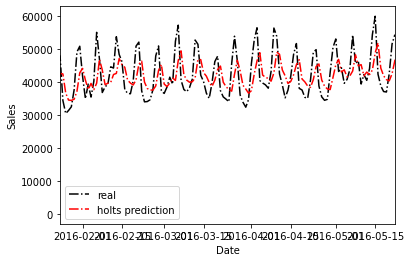

This is for:   CA


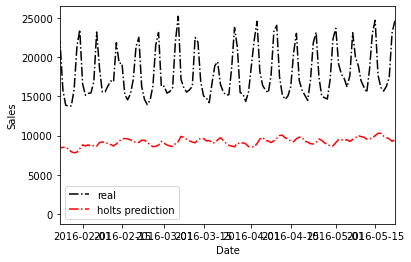

This is for:   TX


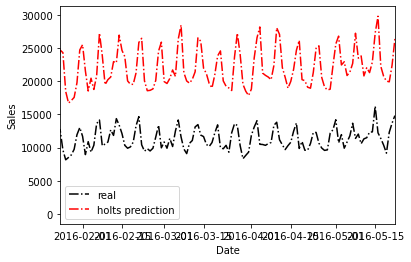

This is for:   WI


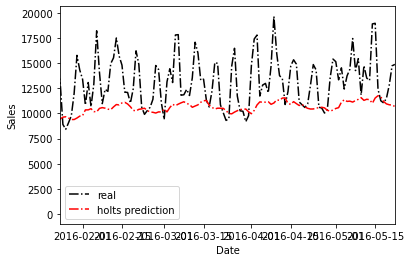

This is for:   CA_1


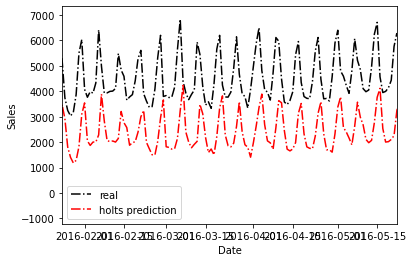

This is for:   CA_2


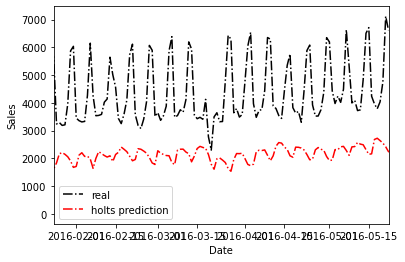

This is for:   CA_3


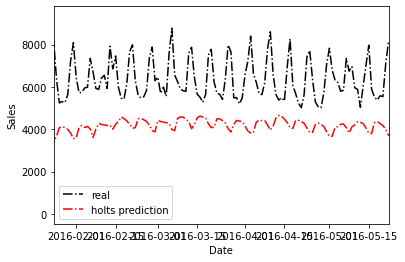

This is for:   CA_4


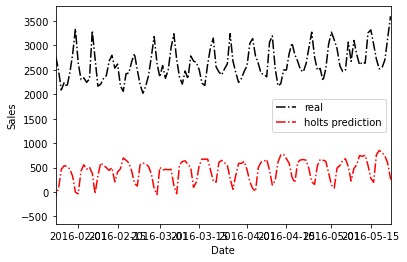

This is for:   TX_1


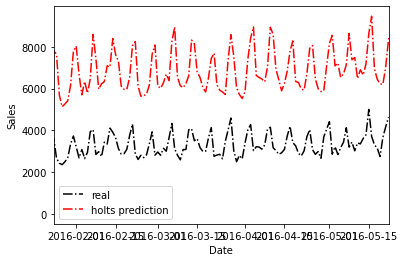

This is for:   TX_2


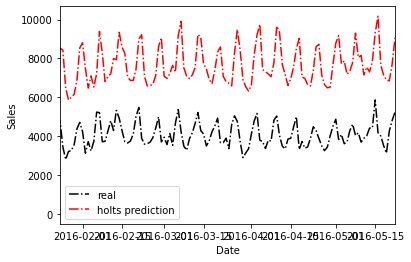

This is for:   TX_3


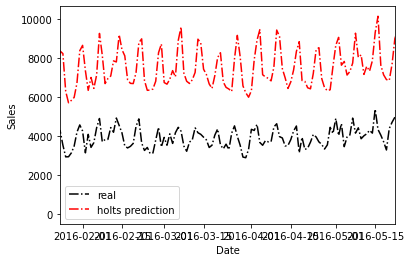

This is for:   WI_1


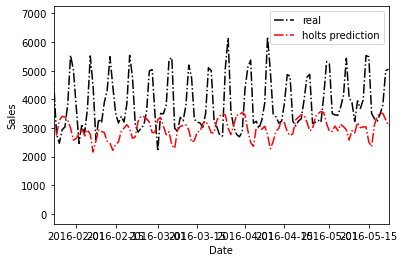

This is for:   WI_2


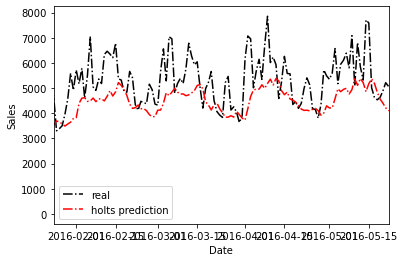

This is for:   WI_3


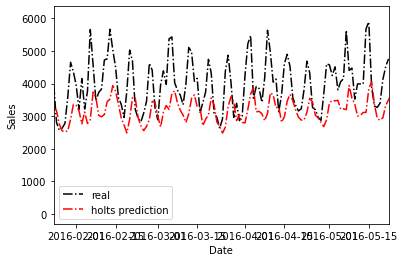

In [31]:
for col_names in prediction:
    print("This is for:  ", col_names)
    plt.plot(combinedframe[col_names],'k-.', label='real')
    plt.plot(prediction[col_names],'r-.', label='holts prediction')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xlim('2016-01-24', '2016-05-22')
    plt.legend()
    plt.show()




In [41]:
for col in combinedframe: 
    print(col, "mean is: ")
    print(combinedframe[col].mean())
    print("\n")
    

CA mean is: 
15042.100463678516


TX mean is: 
9906.442555383823


WI mean is: 
9532.226172076249


CA_1 mean is: 
4035.1612570839775


CA_2 mean is: 
2997.627511591963


CA_3 mean is: 
5854.477073673364


CA_4 mean is: 
2154.8346213292116


TX_1 mean is: 
2932.9330242143224


TX_2 mean is: 
3776.2194744976814


TX_3 mean is: 
3197.2900566718185


WI_1 mean is: 
2710.719216898506


WI_2 mean is: 
3450.7923750644


WI_3 mean is: 
3370.714580113344


HOBBIES mean is: 
3215.1756826378155


HOUSEHOLD mean is: 
7606.434827408552


FOODS mean is: 
23659.15868109222


HOBBIES_1 mean is: 
2936.122617207625


HOBBIES_2 mean is: 
279.0530654301906


HOUSEHOLD_1 mean is: 
6039.594538897475


HOUSEHOLD_2 mean is: 
1566.8402885110768


FOODS_1 mean is: 
2674.0855229263266


FOODS_2 mean is: 
4015.9840288511077


FOODS_3 mean is: 
16969.089129314787


total mean is: 
34480.76919113859




In [37]:
combinedframe.total.mean()

34480.76919113859